In [1]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_stochastic, SEIR_stochastic, plot_samples

# Load and Prep Data

In [2]:
import jhu
import covidtracking
import states

# world data
world = jhu.load_world()

pop = {
    'Italy': 60.48e6,
    'US': 3.27e8,
}

data = {
    'Italy': world.Italy.tot,
    'US': world.US.tot
}

# US state data
US = covidtracking.load_us()
traits = states.uga_traits()

state_pop = { k: traits.totalpop[k] for k in traits.index }
state_data = { k: US[k] for k in US.columns.unique(level=0) }

# combine them
data = dict(data, **state_data)
pop = dict(pop, **state_pop)

# Run Inference

sample: 100%|██████████| 2000/2000 [01:51<00:00, 17.86it/s, 127 steps of size 1.59e-02. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0   8906.89   9151.27   6375.23     38.64  18768.02    460.58      1.00
        I0   7208.95   1282.41   7016.97   5330.45   9137.11    609.68      1.00
   beta[0]      1.42      0.72      1.24      0.54      2.42    530.13      1.00
   beta[1]      1.42      0.71      1.24      0.49      2.33    540.83      1.00
   beta[2]      1.43      0.70      1.26      0.51      2.39    536.34      1.00
   beta[3]      1.45      0.72      1.28      0.49      2.35    590.60      1.00
   beta[4]      1.46      0.73      1.28      0.53      2.37    592.97      1.00
   beta[5]      1.47      0.72      1.31      0.54      2.39    606.15      1.00
   beta[6]      1.47      0.71      1.30      0.51      2.34    606.69      1.00
   beta[7]      1.45      0.70      1.31      0.51      2.34    587.19      1.00
   beta[8]      1.43      0.69      1.28      0.51      2.39    580.61      1.00
   beta[9]      1.39      0

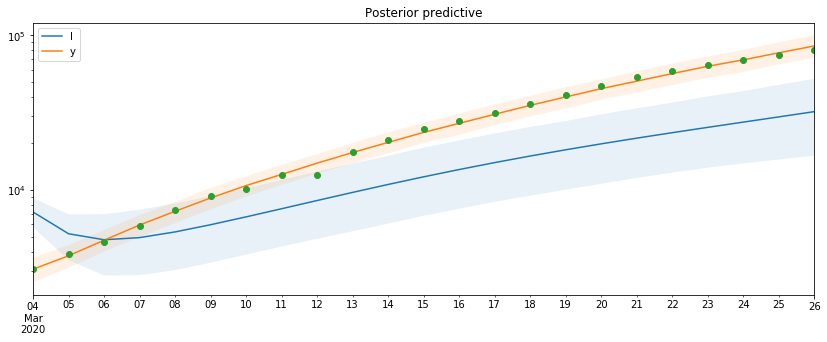

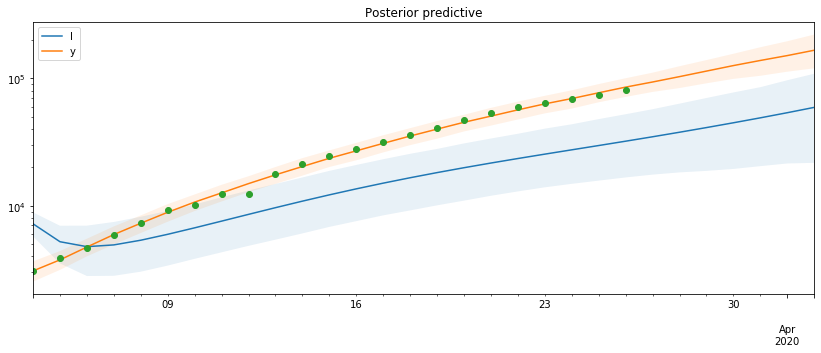

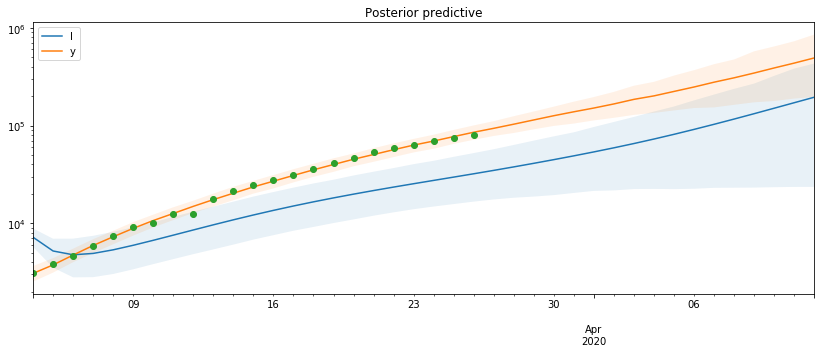

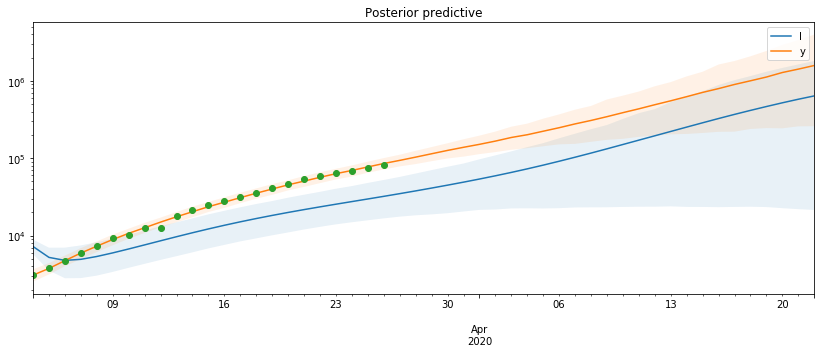

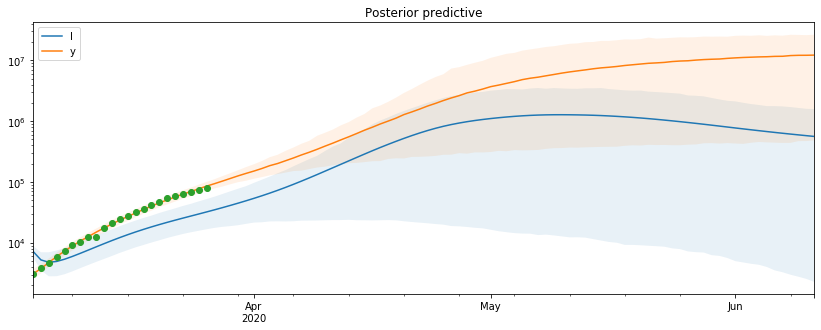

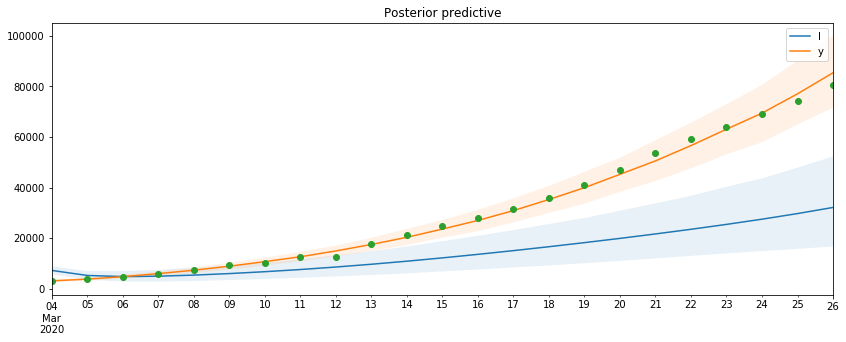

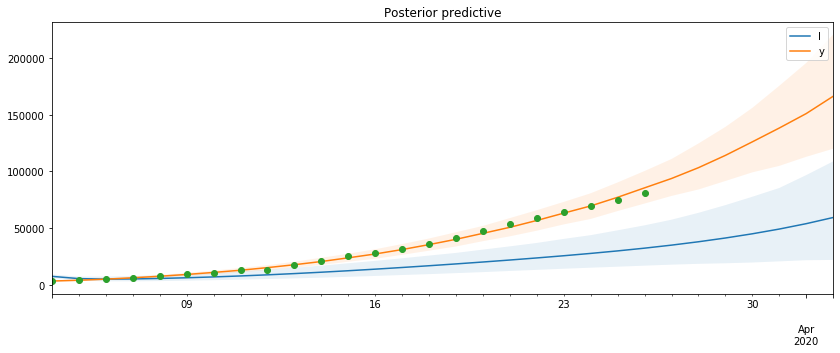

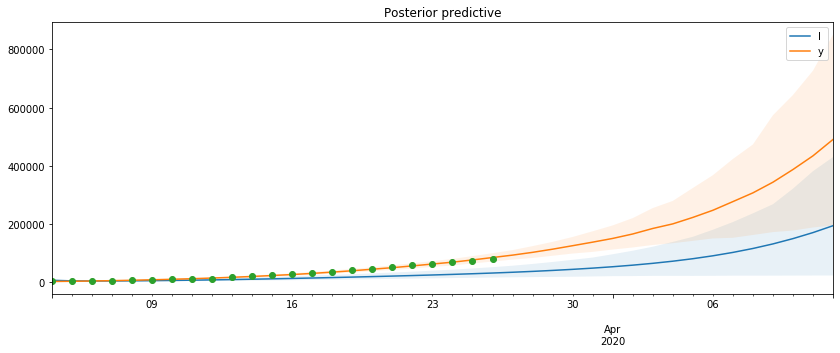

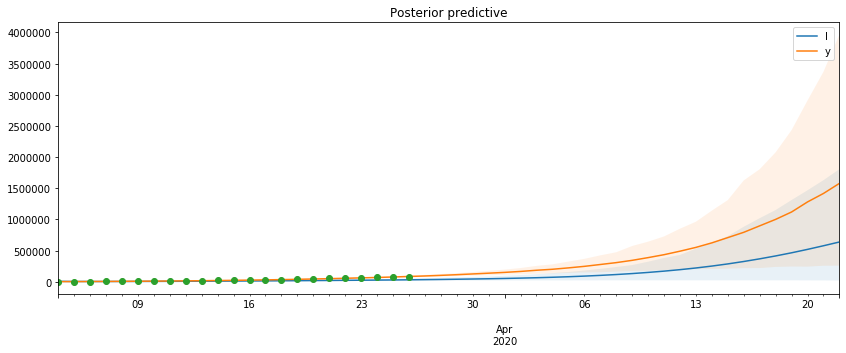

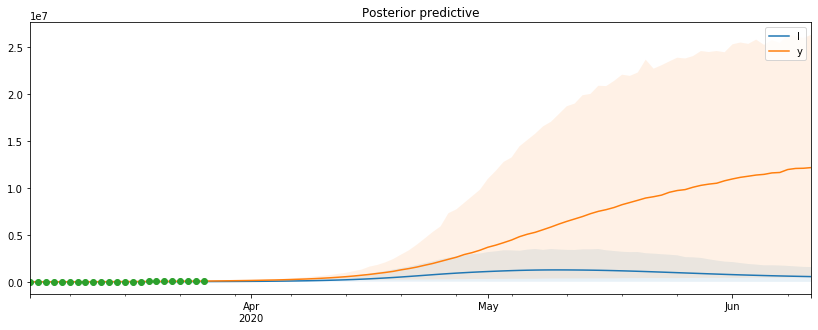

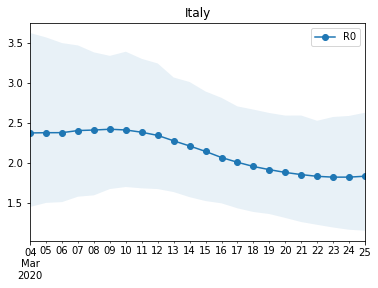

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
import sys

for place in ['Italy', 'US', 'WA', 'NY', 'MA']:

    start = pd.Timestamp('2020-03-04')
    confirmed = data[place].confirmed[start:]
    start = confirmed.index.min()

    T = len(confirmed)
    N = pop[place]

    args = {
        'N': N,
        'T': T,
        'drift_scale': 1e-1,
        'det_conc': 100,
    }

    """
    Specify initial parameters --- inference routines seem
    unable to do this successfully on their own.

    WARNING: BE CAREFUL WITH init DICTIONARY. It is possible
    that including extra parameters will cause inference to
    diverge. It is safest to add only the parameters of the
    model being run.
    """

    I_dur = 1.5
    E_dur = 4.0
    R0 = 3.5

    model = 'SEIR'

    init = {
        'I0': 1000.,
        'gamma': 1 / I_dur,
        'beta0': R0 / I_dur,
        'beta': np.repeat(R0 / I_dur, T-1),
        'det_rate' : 0.3,
    }


    if model == 'SEIR':
        prob_model = SEIR_stochastic
        init['E0'] = 1000.
        init['sigma'] = 1 / E_dur
    elif model == 'SIR':
        prob_model = SIR_stochastic
    else:
        raise ValueError("Bad model")

    kernel = NUTS(prob_model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1)

    mcmc.run(jax.random.PRNGKey(2), 
             obs = confirmed.values,
             init_params = init,
             **args)

    mcmc.print_summary()
    mcmc_samples = mcmc.get_samples()

    # Posterior predictive samples for visualization
    post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
    post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

    # Save samples
    filename = f'out/{place}_samples.npz'
    np.savez(filename, mcmc_samples, post_pred_samples)

    # Write diagnostics to file
    filename = f'out/{place}_summary.txt'
    orig_stdout = sys.stdout
    with open(filename, 'w') as f:
        sys.stdout = f
        mcmc.print_summary()

    sys.stdout = orig_stdout

    # Inspect and Save Results

    for scale in ['log', 'lin']:
        for T in [len(confirmed), 30, 40, 50, 100]:

            t = pd.date_range(start=start, periods=T, freq='D')

            fig, ax = plt.subplots(figsize=(14,5))
            plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'], model=model)
            plt.title('Posterior predictive')

            confirmed.plot(style='o')

            if scale == 'log':
                plt.yscale('log')

            filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.pdf'
            plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': R0.mean(axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)

    plt.title(place)
    plt.show()


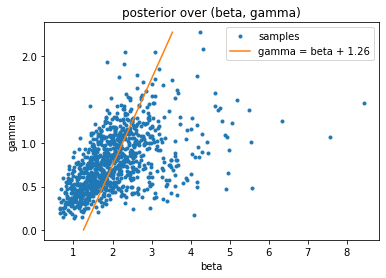

R0: 2.9294224


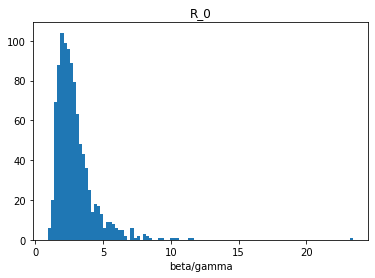

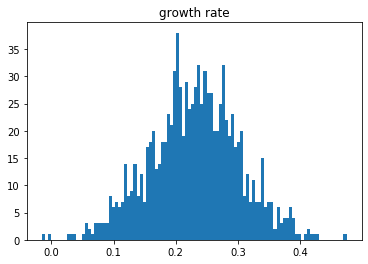

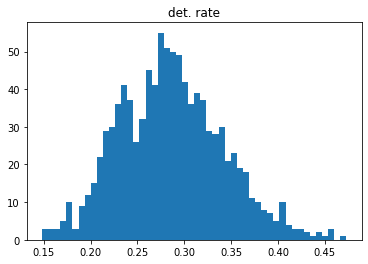

In [44]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, obs_rate = SIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)    
    l2 = ax2.plot(ts, y, 'x', color='r')
        
    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=50, T_future=50, N=1e8)
        
    test_prior_predictive()

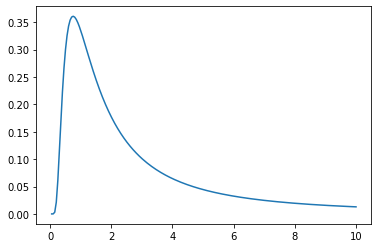

In [4]:
d = dist.Gamma(1, 1 * 1.5)
e = dist.TransformedDistribution(d, dist.transforms.PowerTransform(-1))
x = np.linspace(0, 10, 200)
plt.plot(x, np.exp(e.log_prob(x)))

